# Sign Language Classification - Part A
> Training Our Model for Classifying Sign Language

- toc: false
- branch: master
- badges: true
- comments: true
- categories: [tutorial]
- image: images/header-asl.jpg

# Introduction

I am going to attempt to use Deep Learning to create a model that can learn the American Sign Language. For this Part A, we will focus on model training and for Part B, we are going to create an application from our model that we get here.

We are going to utilize Transfer Learning for this project, which is an important part of Deep Learning.

While I do not claim that this will be the best application out there for this particular problem, this small project could serve as motivation and can be expanded in future to create products that help the affected people who must use sign language to communicate.

In [ ]:
#hide
!pip install -Uqq fastbook
import fastbook
fastbook.setup_book()

     |████████████████████████████████| 727kB 8.3MB/s 
     |████████████████████████████████| 194kB 12.3MB/s 
     |████████████████████████████████| 51kB 7.9MB/s 
     |████████████████████████████████| 1.2MB 16.2MB/s 
     |████████████████████████████████| 61kB 11.0MB/s 
Mounted at /content/gdrive


# Importing Packages

We are going to be using `fastai` so let's import it:

In [ ]:
#hide
from fastbook import *

In [ ]:
from fastai.vision.all import *

# The Data

The dataset we are going to be using is [American Sign Language Dataset](https://www.kaggle.com/grassknoted/asl-alphabet) from Kaggle. It contains 87,000 images each of 200x200 pixels. It has 29 classes: 26 for the letters A-Z and 3 classes for `space`, `delete` and `nothing`. We are going to use the Kaggle API to get the data.

In [ ]:
#hide
!mkdir ~/.kaggle
!mkdir data

!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d grassknoted/asl-alphabet

100% 1.03G/1.03G [00:05<00:00, 222MB/s]



Let's unzip the data and get rid of the zip file:

In [ ]:
#collapse-output
!unzip *zip -d data && rm -rf *zip

In [ ]:
#hide
!mv data/asl_alphabet_train/asl_alphabet_train/* data/asl_alphabet_train/ && rm -rf data/asl_alphabet_train/asl_alphabet_train/
!mv data/asl_alphabet_test/asl_alphabet_test/* data/asl_alphabet_test/ && rm -rf data/asl_alphabet_test/asl_alphabet_test/

We create a `Pathlib` object pointing to our data folder and look inside to see what it contains:

In [ ]:
path = Path('data')
Path.BASE_PATH = path

In [ ]:
path.ls()

(#2) [Path('asl_alphabet_test'),Path('asl_alphabet_train')]

Let's peek into one of those folders:

In [ ]:
(path/'asl_alphabet_train').ls()

(#29) [Path('asl_alphabet_train/X'),Path('asl_alphabet_train/G'),Path('asl_alphabet_train/V'),Path('asl_alphabet_train/I'),Path('asl_alphabet_train/space'),Path('asl_alphabet_train/N'),Path('asl_alphabet_train/W'),Path('asl_alphabet_train/P'),Path('asl_alphabet_train/H'),Path('asl_alphabet_train/Z')...]

We have 29 folders, as explained earlier.

# Data Preprocessing

Now we are ready to create a `DataBlock` blueprint to hold our data. We use the fastai DataBlock API which is a convenient way to define how to handle our data.

Since we don't have validation data provided, we will split 20% of the training images and use it as our validation data.

We then create a `DataLoaders` object from the DataBlock, we will use a batch-size of 64.

In [ ]:
signs = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    get_y=parent_label,
    splitter=RandomSplitter(seed=42, valid_pct=0.2),
    item_tfms=Resize(200),
    batch_tfms=aug_transforms()
)

dls = signs.dataloaders(path/'asl_alphabet_train', bs=64)

Let's look into one batch of the data:

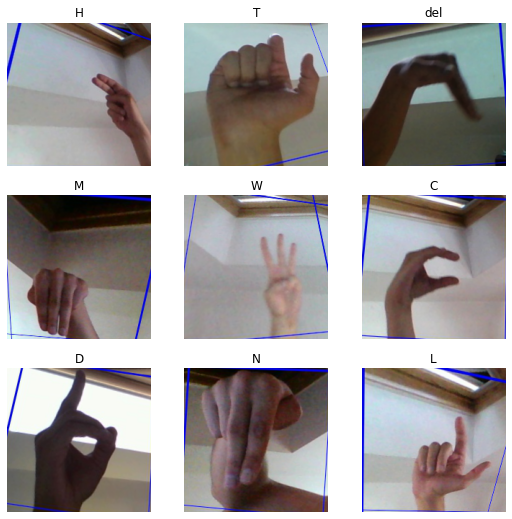

In [ ]:
dls.show_batch()

This is the number of steps we are going to take in an epoch:

In [ ]:
len(dls.train)

1087

# Using Transfer Learning to Create A Model

Now we can create a model and use `Transfer Learning` to train it on our data. Transfer Learning is important since it enables us to get good results with less training and data.

For those who wish to replicate this experiment, we use: `resnet18` architecture, `Cross Entropy Loss` since this is a Classification Task, and for our optimizer, we select the `Adam` Optimizer. We will output error rate and accuracy as our metrics to help as analyze how our model is doing.

We use the `Learning Rate Finder` provided by fastai, using insights from Leslie Smith's work, that enable us to find us a good learning rate, in short time instead of us trying a couple of learning rates experimentally and seeing what works.

If you are interested in reading more about the Learning Rate Finder, read [this paper](https://arxiv.org/abs/1506.01186).


For our tast, it looks like a learning rate of 1x10<sup>-2</sup> will work, so we fine-tine (transfer learn) for 4 epochs.

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth


SuggestedLRs(lr_min=0.017378008365631102, lr_steep=0.015848932787775993)

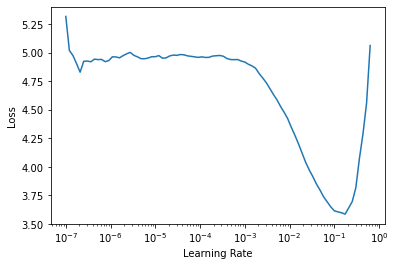

In [ ]:
learn = cnn_learner(dls, resnet18, loss_func=CrossEntropyLossFlat(),
                    metrics=[error_rate, accuracy], opt_func=Adam)

learn.lr_find()

In [ ]:
learn = cnn_learner(dls, resnet18, loss_func=CrossEntropyLossFlat(),
                    metrics=[error_rate, accuracy], opt_func=Adam)

learn.fine_tune(4, base_lr=1e-2)

epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.230984,0.065030,0.019310,0.980690,04:11


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.160366,0.875754,0.117989,0.882011,05:24
1,0.038482,0.008822,0.002529,0.997471,05:26
2,0.008333,0.000855,0.000230,0.999770,05:25
3,0.002372,0.000346,0.000057,0.999943,05:25


We get a very good accuracy only after 4 epochs.

Now we can tackle the small test set that comes with this dataset, although we will scale up to a better test dataset in a few moments.

# Testing Our Model

In [ ]:
test_images = (path/'asl_alphabet_test').ls()
test_images

(#28) [Path('asl_alphabet_test/U_test.jpg'),Path('asl_alphabet_test/space_test.jpg'),Path('asl_alphabet_test/N_test.jpg'),Path('asl_alphabet_test/R_test.jpg'),Path('asl_alphabet_test/H_test.jpg'),Path('asl_alphabet_test/P_test.jpg'),Path('asl_alphabet_test/T_test.jpg'),Path('asl_alphabet_test/C_test.jpg'),Path('asl_alphabet_test/X_test.jpg'),Path('asl_alphabet_test/V_test.jpg')...]

We have 28 images in this test set, each for the classes of data we have.

Let's take the first two images and predict them using our model.

In [ ]:
U = (path/'asl_alphabet_test'/'U_test.jpg')
space = (path/'asl_alphabet_test'/'space_test.jpg')

In [ ]:
learn.predict(U)[0]

'U'

In [ ]:
learn.predict(space)[0]

'space'

That looks like its working well. To predict on all the images in the test set, we are going to need a way to get the labels of the images, so as to compare with our prediction.

Let's work with one image first:

In [ ]:
u_test = test_images[0]
u_test

Path('asl_alphabet_test/U_test.jpg')

As you can see, the label of the test images is contained in the filename. So we are going to use regular expressions to extract the label from the filenames.

Here is a simple regular expression that does the job:

In [ ]:
re.findall('(.+)_test.jpg$', u_test.name)[0]

'U'

And our prediction on that image:

In [ ]:
learn.predict(u_test)[0]

'U'

And now, a way to compare our prediction, to the true label of the test set:

In [ ]:
re.findall('(.+)_test.jpg$', u_test.name)[0] == learn.predict(u_test)[0]

True

Let us write a function that is going to extract the labels, and store them in a list:

In [ ]:
def get_test_names(images):
  labels = []

  for i in images:
    label = re.findall('(.+)_test.jpg$', i.name)[0]
    labels.append(label)
  
  return labels

We can now get all the labels for the 28 images in our test set:

In [ ]:
test_labels = get_test_names(test_images)

In [ ]:
len(test_labels)

28

Now we need a function to run inference on the images. It is going to take in the images, our model and the labels we just got as parameters and output the mean accuracy of our predictions:

In [ ]:
def run_inference(images, model, labels):
  corrects = []
  # get the number of images to inference
  num_images = len(images)

  for i in range(num_images):
    # get the inference for an image
    prediction = model.predict(images[i])[0]

    # compare with the label for that image
    is_equal = (prediction==labels[i])

    # append result to the list
    corrects.append(is_equal)
  
  # convert the list of inferences to float Tensor
  corrects = torch.Tensor(corrects).float()
  
  # return the mean accuracy
  return corrects.mean().item()

We can use that function to get the mean accuracy of our model on the small test dataset.

In [ ]:
test_accuracy = run_inference(test_images, learn, test_labels)

test_accuracy

1.0

We get 100% accuracy. Impressive. But as I mentioned earlier, this is a small dataset, that doesn't do well to tell us how our model will generalize to new data.

Luckily, there is another dataset recommended to be used as a test set for this dataset. It contains 870 images, 30 images for each category.

Let us use the Kaggle API again to get this new dataset:

In [ ]:
!kaggle datasets download -d danrasband/asl-alphabet-test

 70% 17.0M/24.3M [00:00<00:00, 24.5MB/s]
100% 24.3M/24.3M [00:00<00:00, 33.3MB/s]


And unzip it to a test folder:

In [ ]:
#collapse-output
!unzip *zip -d test && rm -rf *zip

In [ ]:
#hide
!rm -rf test/asl-alphabet-test/

In [ ]:
test_path = Path('test')
test_path.ls()

(#29) [Path('test/X'),Path('test/G'),Path('test/V'),Path('test/I'),Path('test/space'),Path('test/N'),Path('test/W'),Path('test/P'),Path('test/H'),Path('test/Z')...]

We use the `get_image_files` to recursively get images from the newly-created test path. We get 870 images, so that seems to be working fine.

In [ ]:
test_files = get_image_files(test_path)

len(test_files)

870

To run inference, we are required to perform the same data preprocessing we perfomed on the training images. To make this easier, fastai suggest we use a `test_dl` that is created using the following syntax:

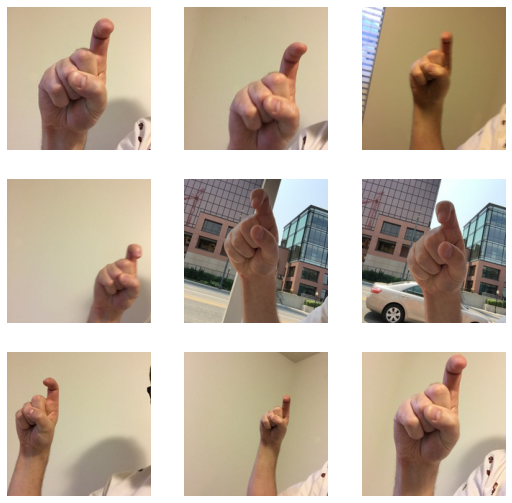

In [ ]:
test_dl = learn.dls.test_dl(test_files, with_label=True)

test_dl.show_batch()

We can now get the predicitons on all the test images easily using the get_preds function and store it in a test_preds variable.

In [ ]:
test_preds = learn.get_preds(dl=test_dl)  

This are our current vocabs of our data:

In [ ]:
learn.dls.vocab

['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'del', 'nothing', 'space']

To extract the true labels from the test images, we are again going to turn to regular expressions. But this time, we are required to write a regular expression robust enough to handle this three cases that represent how the rest of the images are named:

In [ ]:
example_name = test_dl.items[370].name
example_name

'del0002_test.jpg'

In [ ]:
re.findall(r'([A-Za-z]+)\d+_test.jpg$', example_name)[0] 

'del'

In [ ]:
example_name_2 = test_dl.items[690].name
example_name_2

'nothing0013_test.jpg'

In [ ]:
re.findall(r'([A-Za-z]+)\d+_test.jpg$', example_name_2)[0]

'nothing'

In [ ]:
example_name_3 = test_dl.items[0].name
example_name_3

'X0023_test.jpg'

In [ ]:
re.findall(r'([A-Za-z]+)\d+_test.jpg$', example_name_3)[0]

'X'

Now that we have that robust expression, we can proceed to check the accuracy of our prediction that we calculated:

We create a list to hold the result of our comparisons, from the predictions and the true labels, which we are going to use to calculate the final accuracy.

We also create a category_corrects dictionary, to tally for us, for each category, how many we predicted correct, so that we can see how our model performs on each category individually.

In [ ]:
# create a list to hold True or False when comparing
corrects = []

# count how many predictions we get correct per category
category_corrects = dict.fromkeys(learn.dls.vocab, 0)

# for each enumerated predictions
for index, item in enumerate(test_preds[0]):
  # get the predicted vocab
  prediction = learn.dls.categorize.decode(np.argmax(item))
  # get the confidence of the prediction
  confidence = max(item) 
  confidence_percent = float(confidence)
  # get the true label for the image we are predicting
  image_name = test_dl.items[index].name
  label = re.findall(r'([A-Za-z]+)\d+_test.jpg$', image_name)[0]
  # get the comparison and append it to our corrects list
  is_correct = (prediction==label)
  corrects.append(is_correct)

  # if we got the prediction correct for that category,
  # increase the count by one
  if is_correct:
    category_corrects[prediction] += 1


# convert the list of inferences to float Tensor
corrects = torch.Tensor(corrects).float()

# print the mean accuracy
print(f'Accuracy on the test set: {corrects.mean().item():.4f}')

Accuracy on the test set: 0.6195


As you can see, using this better test set, we can see that the accuracy reduces.

Since this is out of domain data, my intuition is that a better dataset that varies more could be collected and used in future. However for now, let's work with these results.

Remember, the test set is used as a final measure, and we shouldn't use it to improve our model

Let us check on the per-category prediction:

In [ ]:
category_corrects

{'A': 15,
 'B': 30,
 'C': 17,
 'D': 25,
 'E': 19,
 'F': 13,
 'G': 13,
 'H': 30,
 'I': 29,
 'J': 22,
 'K': 21,
 'L': 29,
 'M': 22,
 'N': 14,
 'O': 19,
 'P': 30,
 'Q': 29,
 'R': 17,
 'S': 7,
 'T': 0,
 'U': 11,
 'V': 0,
 'W': 27,
 'X': 4,
 'Y': 28,
 'Z': 11,
 'del': 23,
 'nothing': 14,
 'space': 20}

A plot would be better to analyze the information:

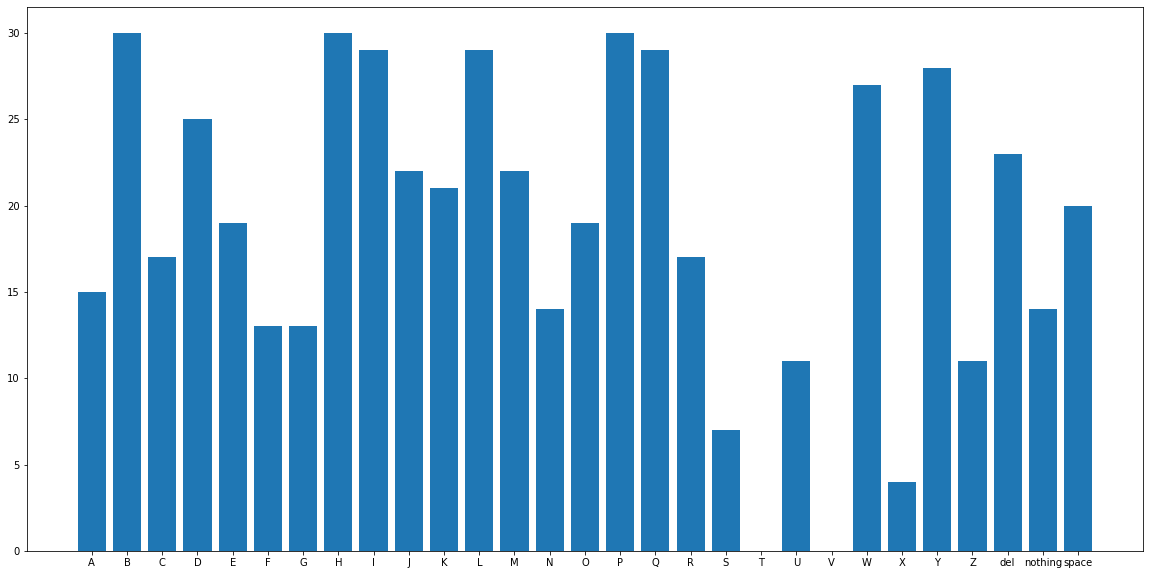

In [ ]:
fig, ax = plt.subplots(figsize=(20, 10))
ax.bar(*zip(*category_corrects.items()))
plt.show()

Our model performs really poorly on the letters T, V, and X!!
We will see if this is going to be a problem in our Application that we create in part 2.

# Making our Inference Model More Robust

Since I plan on using this model to create a Computer Vision Model, I deciced to retrain my model, adding the new dataset in order to make it more robust, since that data varied more.

**NOTE: This is not how it should be done, you should never use your test set to train the model. I only combined the two datasets into one in order to get a better model since good Sign Language Data is hard to come by and the test set we used isn't the official test set, just a recommended dataset that could have been used for training a different model. Also, I didn't use my new model to get a better prediction on the test set.**

In [ ]:
#hide
!cp -vr test/* data/asl_alphabet_train/

In [ ]:
signs = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    get_y=parent_label,
    splitter=RandomSplitter(seed=42),
    item_tfms=Resize(200),
    batch_tfms=aug_transforms()
)

dls = signs.dataloaders(path/'asl_alphabet_train', bs=64)

In [ ]:
len(dls.train)

1098

In [ ]:
learn = cnn_learner(dls, resnet18, loss_func=CrossEntropyLossFlat(),
                    metrics=[error_rate, accuracy], opt_func=Adam)

learn.fine_tune(4, base_lr=1e-2)

epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.248037,0.073583,0.020769,0.979231,04:13


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.121224,0.061025,0.016502,0.983498,05:27
1,0.036989,0.008055,0.001878,0.998122,05:27
2,0.007163,0.003641,0.001081,0.998919,05:27
3,0.003785,0.002509,0.000569,0.999431,05:27


I can now export my model, which I will use in the next Part, to create a Computer Vision Model to predict new data. Stay tuned!

In [ ]:
learn.export('sign_language.pkl')